In [1]:
%load_ext autoreload

In [2]:
import os
import math
import random
import statistics

import einops

import numpy as np

import torch
from torch import nn
from torch import Tensor

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

from sklearn import datasets as sk_datasets

In [3]:
%autoreload 2
import utils
from model import SimpleNet, ModelOutput
from samplers import VPSDE, VESDE, DDPM, SBTrainer
from datasets_2d import registry, DatasetSampler

In [4]:
def seed_everython(seed=3407):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everython(3407)

In [5]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ])
    return (R @ mean.T).T


def scatter(tensor):
    plt.scatter(tensor[:, 0], tensor[:, 1])
    

def plot_trajectory(trajectory, timesteps, indices: None | list = None):
    if indices is not None:
        trajectory = [trajectory[i] for i in indices]
        timesteps = [timesteps[i] for i in indices]

    figure, axes  = plt.subplots(1, len(trajectory), figsize=(4 * len(trajectory), 4))
    for i, sample in enumerate(trajectory):
        if type(timesteps[i]) == str:
            title = f'{timesteps[i]}' 
        else:
            title = f'timestep: {round(timesteps[i], 4)}'
        
        axes[i].set_title(title)
        axes[i].scatter(sample[:, 0], sample[:, 1], 
                     c='r' if type(timesteps[i]) == str else 'b')
        axes[i].set_xlim(-1.5, 1.5)
        axes[i].set_ylim(-1.5, 1.5)
    plt.show()
    return figure

# Data

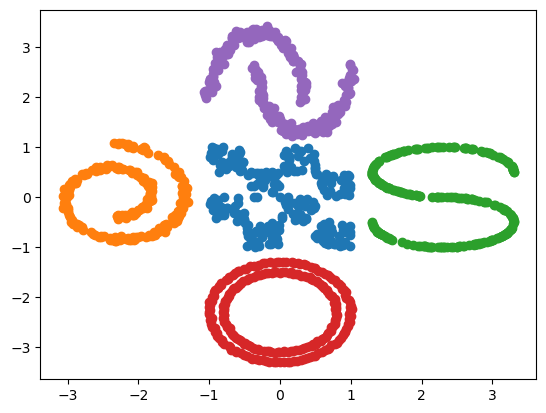

In [6]:
scatter(registry['checkboard'](256))
scatter(registry['swiss_roll'](256, noise=0.3, shift=torch.tensor([[-2.3, 0]])))
scatter(registry['s_curve'](256, noise=0.0, shift=torch.tensor([[2.3, 0]])))
scatter(registry['two_circles'](256, noise=0.01, shift=torch.tensor([[0, -2.3]])))
scatter(registry['two_moons'](256, noise=0.05, shift=torch.tensor([[0, 2.3]])))

plt.show()

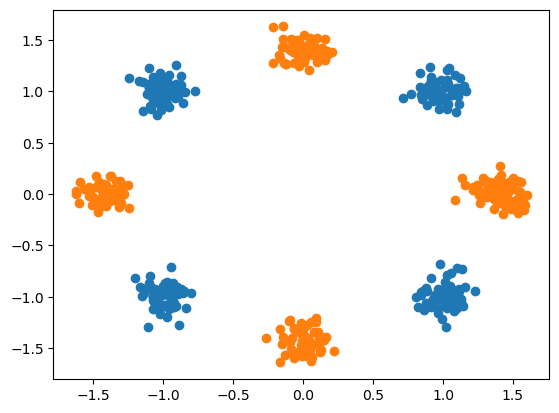

In [7]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigmas = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_1='mix_of_gaussians', p_1_args=[rotate_mean(mean), sigmas],
)

x_0, x_1 = sampler.sample(256)

scatter(x_0)
scatter(x_1)

# DDPM

In [ ]:
def linear_schedule(n_steps):
    scale = 1000 / n_steps
    start, end = scale * 0.0001, scale * 0.02
    return torch.linspace(start, end, n_steps)


model = SimpleNet(64, 64)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
ddpm = DDPM(linear_schedule(100), 100)

loss_history = []
for i in trange(5000):
    x_0, _ = sampler.sample(256)
    t = torch.randint(0, ddpm.n_steps, (x_0.size(0),))
    loss = ddpm.train_loss(model, x_0, t)
    
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())    

  0%|          | 0/5000 [00:00<?, ?it/s]

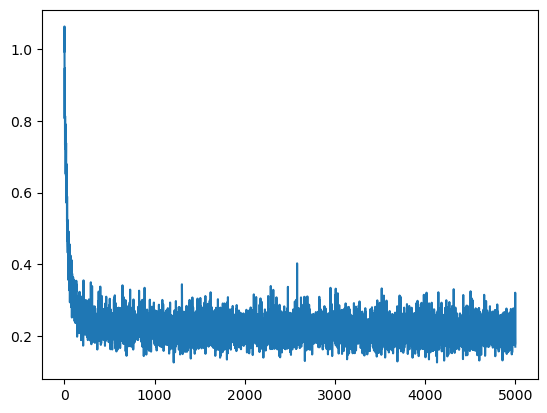

In [ ]:
plt.plot(loss_history)
plt.show()

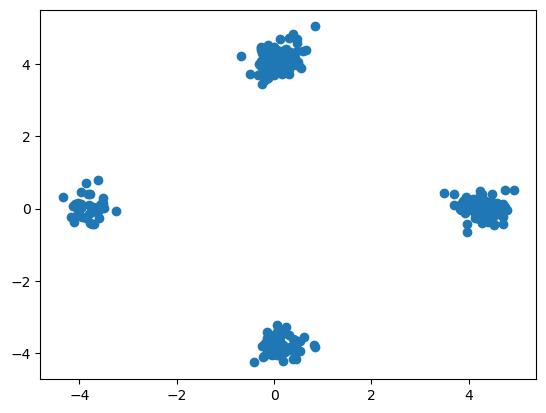

In [ ]:
ddpm = DDPM(linear_schedule(100), 100)
x_t = ddpm.sample(model, (256, 2), sample_with='ansesterial')

scatter(x_t)

# VP SDE

#### draw noising paths

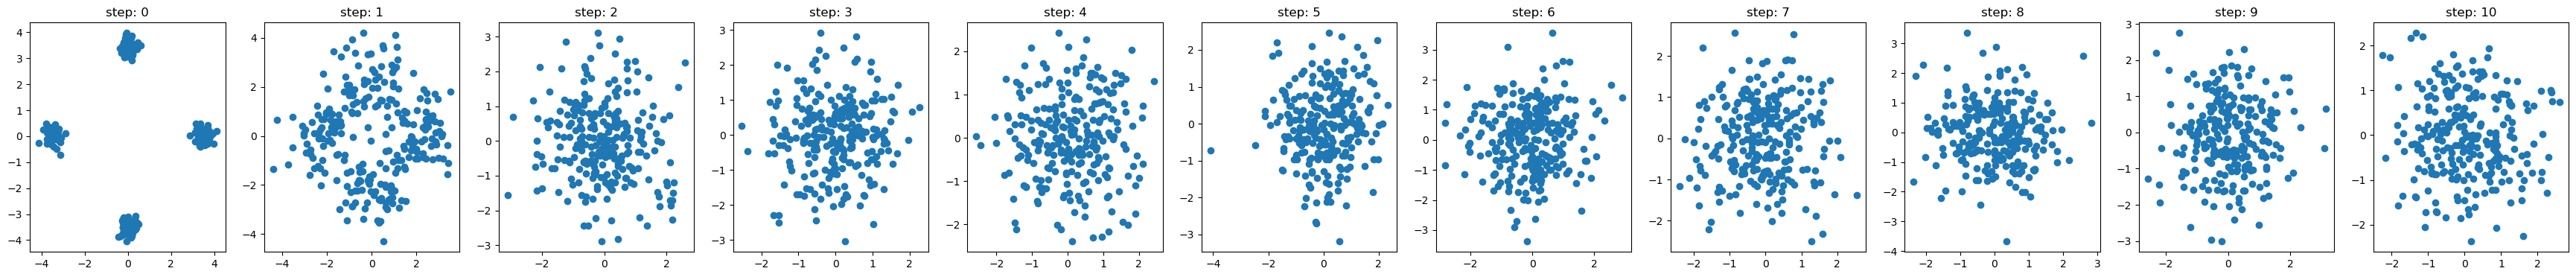

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_0, x_1 = sampler.sample(256)

trajectory = [x_0]
for t in range(vp.n_steps // 10 - 1, vp.n_steps, vp.n_steps // 10):
    t = torch.ones(256) * t / vp.n_steps
    x_t = vp.sample_x_t_from_x_0(x_0, t)
    trajectory.append(x_t)

plot_trajectory(trajectory)

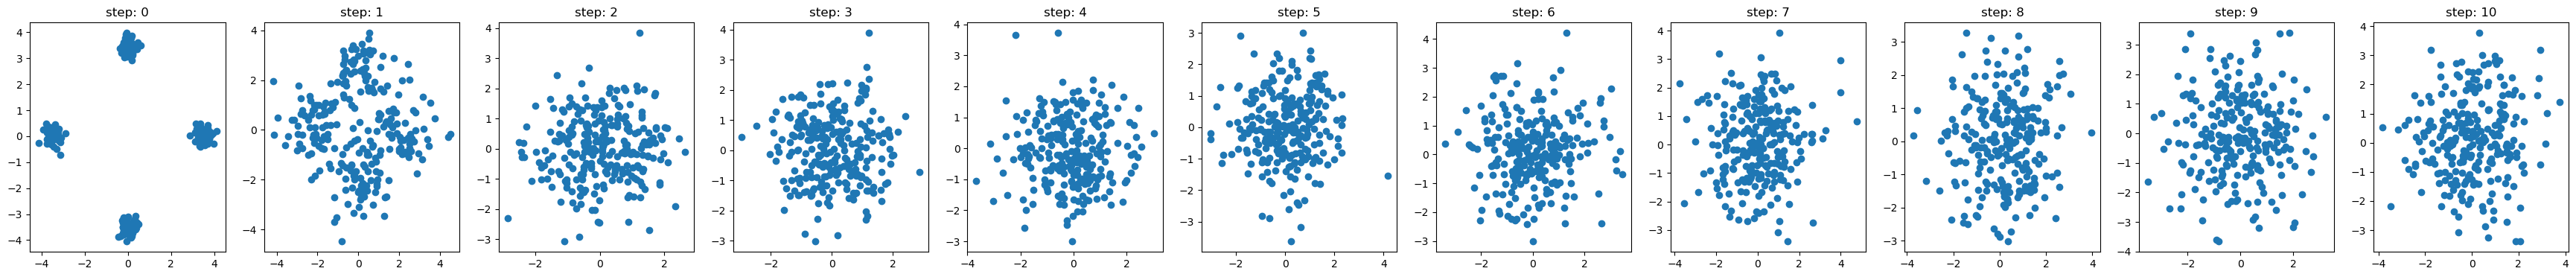

In [ ]:
x_t = x_0.clone()

trajectory = [x_0]
for i in range(vp.n_steps):
    t = torch.ones(256) * i / vp.n_steps
    x_t = x_t + vp.make_fwd_step(x_t, t)
    
    if (i + 1) % (vp.n_steps // 10) == 0:
        trajectory.append(x_t)

plot_trajectory(trajectory)

#### train

In [ ]:
B_SIZE = 256
N_STEPS = 5_000

vp = VPSDE(0.1, 20.0, n_steps=100)
score_model = SimpleNet(64, 64)
optim = torch.optim.AdamW(score_model.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = sampler.sample(B_SIZE)
    t = torch.rand(x_0.size(0))
    
    loss = vp.compute_loss(score_model, x_0, t, learn_score=False)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

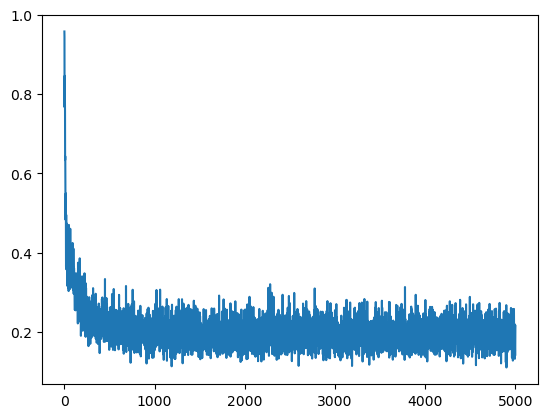

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_t = torch.randn(256, 2)
trajectory = [x_t]

for t in range(vp.n_steps - 1, -1, -1):
    t = torch.maximum(torch.ones(256) * t, torch.as_tensor(1e-3)) / vp.n_steps
    score = vp.score_from_noise(score_model, x_t, t)
    x_t = x_t + vp.make_bwd_step(score, x_t, t, ode_flow=False)
    
    trajectory.append(x_t)


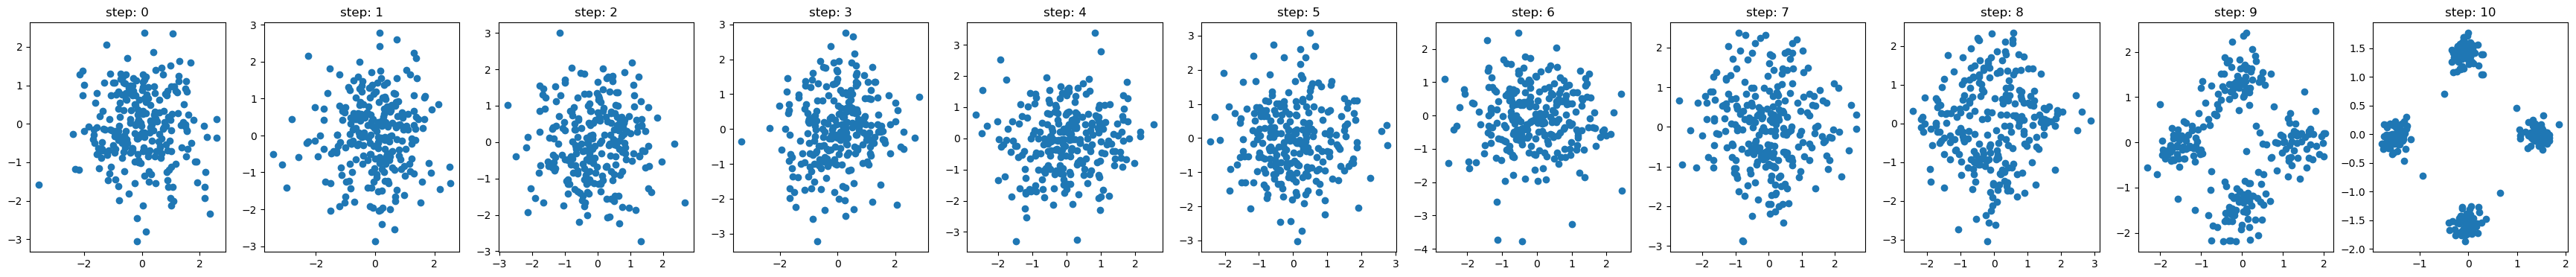

In [ ]:
plot_trajectory([trajectory[i] for i in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 - 1]])
# plot_trajectory(trajectory)

# VESDE & SMLD

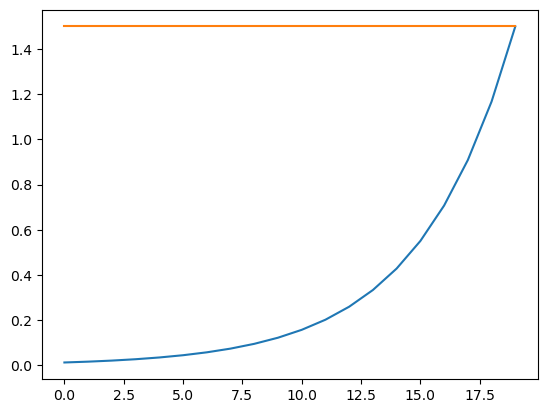

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

step = (sigma_max / sigma_min) ** (1 / n_steps)
sigma_schedule = [sigma_min * step**(i+1) for i in range(n_steps)]
plt.plot(sigma_schedule)
plt.plot([sigma_max] * n_steps)
plt.show()

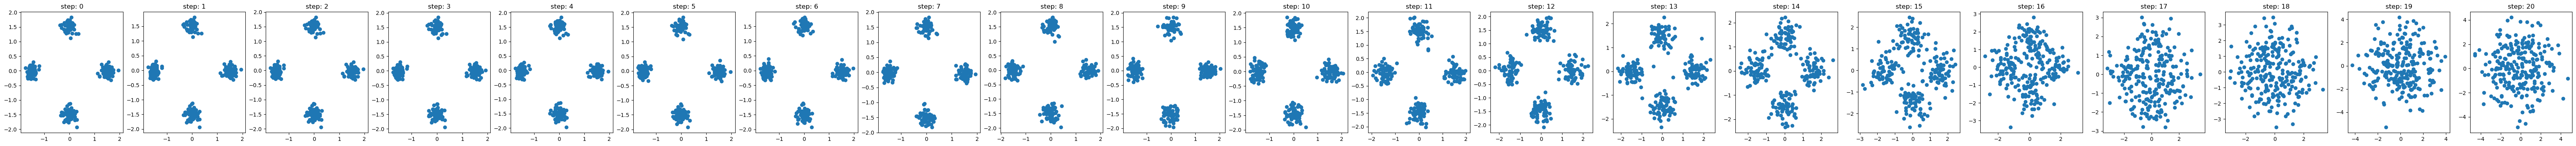

In [ ]:
x_0, _ = sampler.sample(256)

trajectory = [x_0]
for sigma in sigma_schedule:
    trajectory.append(x_0 + torch.randn_like(x_0) * sigma)

plot_trajectory(trajectory)

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

sigma_coeff = (sigma_max / sigma_min) ** (1 / n_steps) 

In [341]:
score = SimpleNet(64, 64)
optim = torch.optim.AdamW(score.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = sampler.sample(256)
    steps = torch.randint(1, n_steps + 1, (x_0.size(0),))
    sigma = extract_into_tensor(sigma_min * (sigma_coeff) ** (steps), x_0.shape)
    
    x_sigma = x_0 + sigma * torch.randn_like(x_0)
    pred_score = score(x_sigma, sigma.squeeze(-1))
    true_score = - (x_sigma - x_0) / sigma**2
    loss = nn.functional.mse_loss(pred_score, true_score)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

NameError: name 'N_STEPS' is not defined

# SB via IPF

In [18]:
@torch.no_grad()
def make_euler_maruyama_step(x, t, dt, f = None, var=2.0, t_max=0.2):        
    log_var = torch.as_tensor(var).log()
    z = torch.randn_like(x)

    output = f(x, t)
    if output.contains('log_var'):
        log_var = output.log_var

    mean = x + output.drift * dt
    return mean + torch.sqrt(log_var.exp() * dt) * z

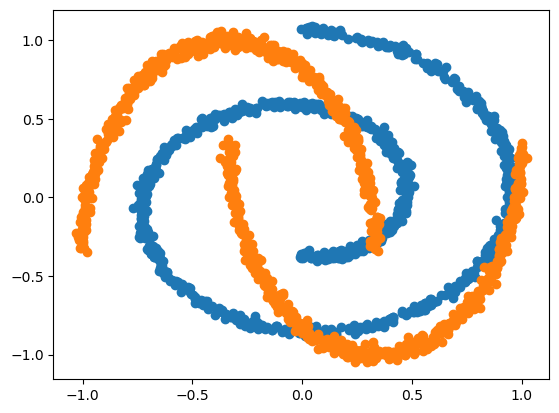

In [19]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='swiss_roll', p_0_args=[None, 0.2],
    p_1='two_moons', p_1_args=[None, 0.02],
    # p_1='checkboard', p_1_args=[None],
)
x_0, x_1 = sampler.sample(1024)
scatter(x_0)
scatter(x_1)
plt.show()

#### Training B via score and mean matching

In [26]:
def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


alpha = 4
gamma = 0.0006
t_max = 0.012
n_steps = 20

Checking reference process

Reference process


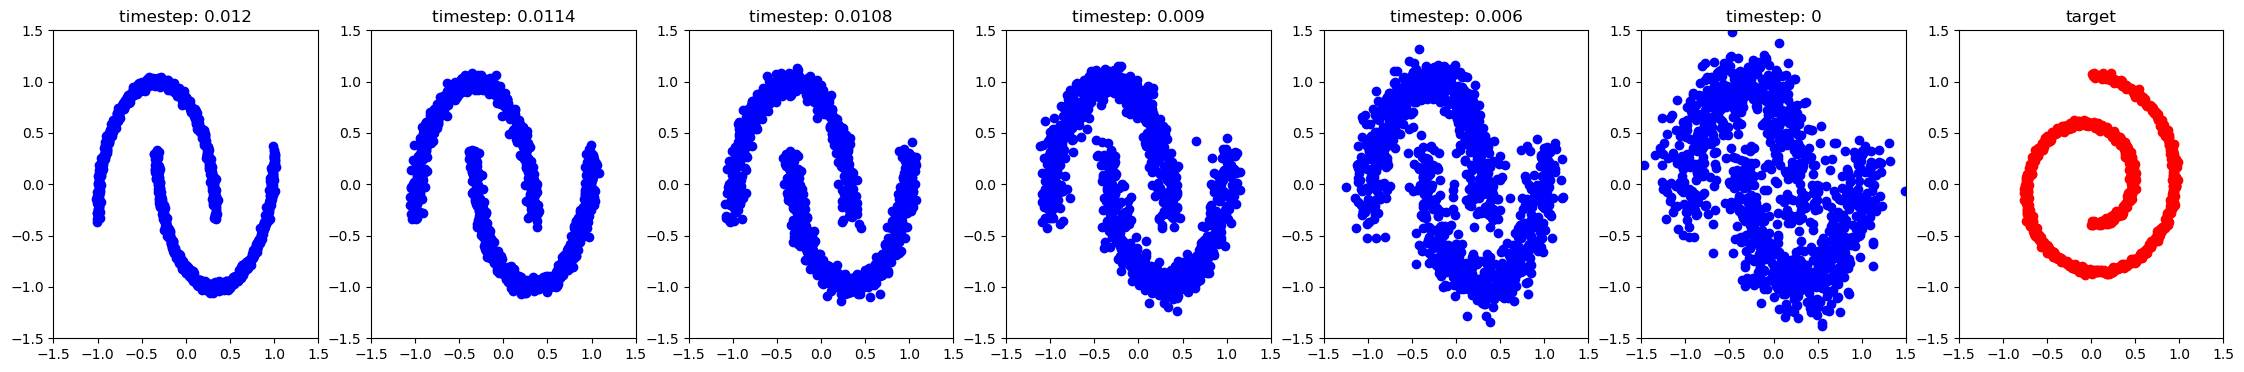

In [52]:
x_0,  x_1 = sampler.sample(1024)

reference_trajectory = [x_1]
timesteps = []
for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
    t = torch.ones(x_1.size(0)) * t_step
    x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process)
    reference_trajectory.append(x_next)
    timesteps.append(t_step.item())

timesteps.append(0)

timesteps.append('target')
reference_trajectory.append(x_0)

print('Reference process')
_ = plot_trajectory(reference_trajectory, timesteps, indices=[0, 1, 2, 5, 10, -2, -1])

In [9]:
def compute_b_model_loss(model, reference, x_t, t, mean: bool = True):
    log_var = torch.as_tensor(2.0 * gamma).log()
    
    with torch.no_grad():
        x_t_m_gamma = make_euler_maruyama_step(x_t, t, gamma, f=reference)
    
    output = model(x_t_m_gamma, t - gamma)
    mean_pred = x_t_m_gamma + gamma * output.drift

    if output.contains('log_var'):
        log_var = output.log_var + log_var

    loss = 0.5 * (log_var + torch.exp(- log_var) * (mean_pred - x_t).pow(2))
    return loss.sum(-1).mean(), x_t_m_gamma

In [852]:
N_MAX_ITER = 2_000
PREDICT_LOGVAR = True
USE_MEAN_MATCHING = True

B_model = SimpleNet(64, 64, n_main_body_layers=3, predict_log_var=PREDICT_LOGVAR)
optim_B = torch.optim.Adam(B_model.parameters(), lr=8e-4)

ema_loss = utils.EMALoss(alpha=0.09)
var_crit = utils.VarCriterion(ema_loss.ema, threshold=5e-6, max_iter=N_MAX_ITER, measure_size=500)

with tqdm(total=N_MAX_ITER, leave=False) as pbar:

    while var_crit.check():
        traj_loss = 0
        optim_B.zero_grad(set_to_none=True)
        
        _, x_t = sampler.sample(512)
        for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
            t = torch.ones(x_t.size(0)) * t_step
                        
            loss, x_t = compute_b_model_loss(B_model, ref_process, x_t, t, mean=USE_MEAN_MATCHING)   
            
            loss.backward()
            traj_loss += loss.item()

        ema_loss.update(traj_loss / n_steps)
        optim_B.step()
        
        pbar.update(1)

    pbar.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

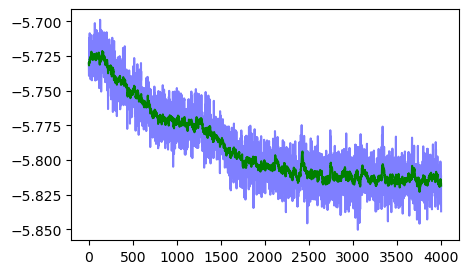

In [894]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.loss, alpha=0.5, c='b')
plt.plot(ema_loss.ema, c='g')
plt.show()

Reference process


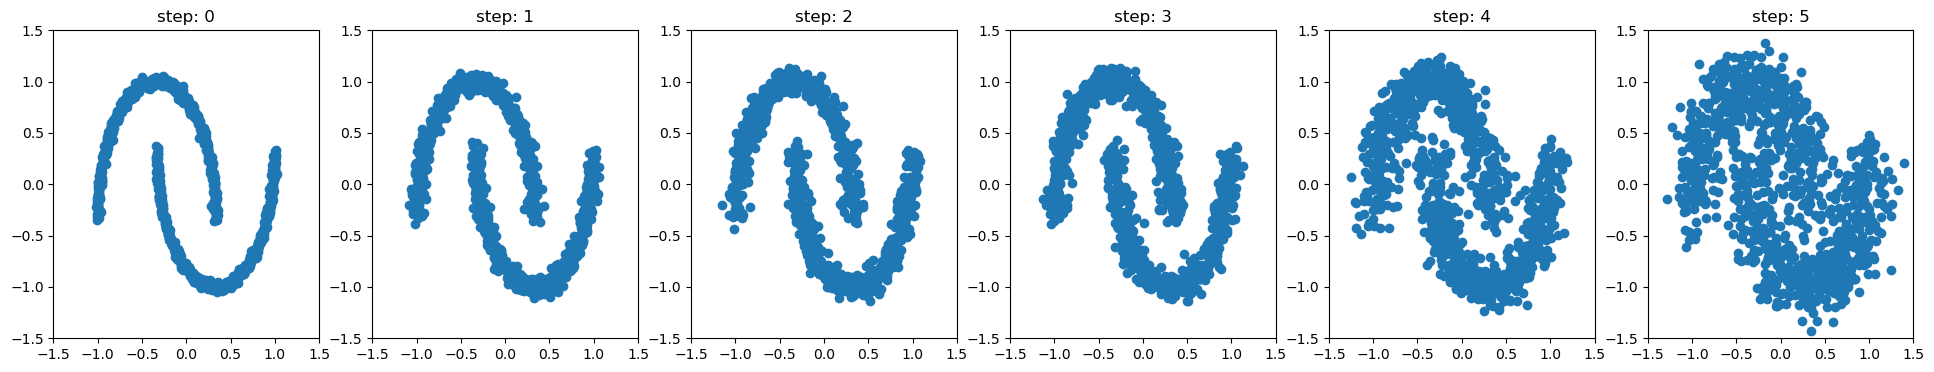

Learned trajectory for B


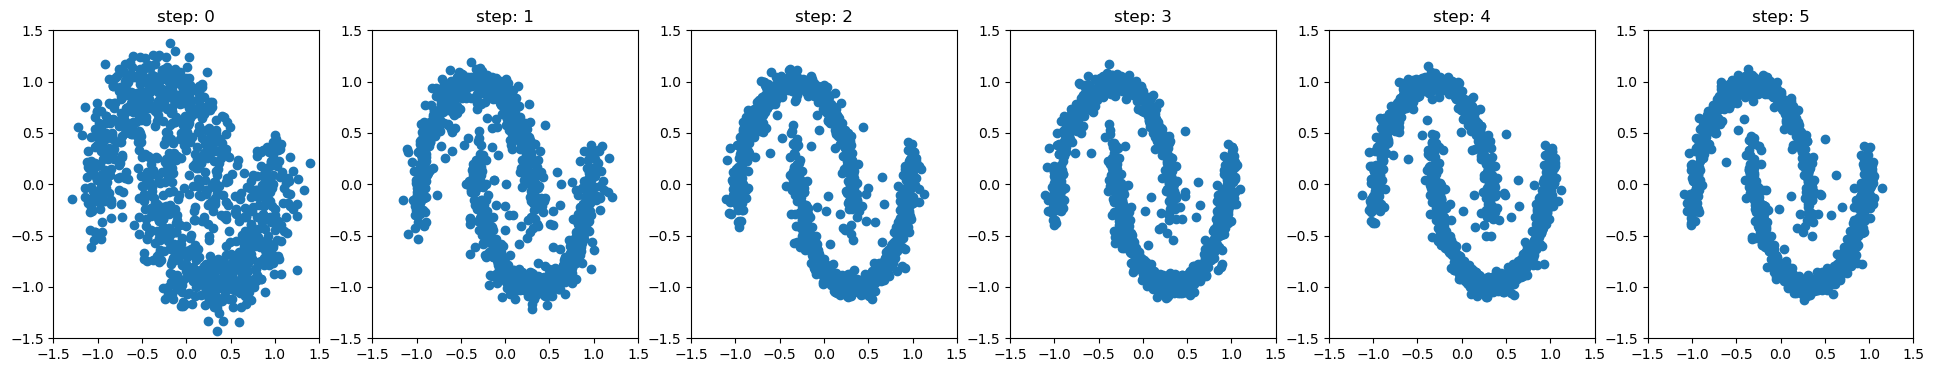

In [854]:
_, x_1 = sampler.sample(1024)


reference_trajectory = [x_1]
for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
    t = torch.ones(x_1.size(0)) * t_step
    x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process)
    reference_trajectory.append(x_next)

print('Reference process')
_ = plot_trajectory(reference_trajectory, indices=[0, 1, 2, 3, 10, -1])


learned_trajectory = [reference_trajectory[-1]]
with torch.no_grad():
    for t_step in torch.linspace(0, t_max - gamma, n_steps):
        t = torch.ones(x_1.size(0)) * t_step
        x_next = make_euler_maruyama_step(learned_trajectory[-1], t, gamma, f=B_model)
        learned_trajectory.append(x_next)

print('Learned trajectory for B')
f = plot_trajectory(learned_trajectory , indices=[0, 10, -4, -3, -2, -1])

#### Training F via score and mean matching

In [866]:
def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


alpha = 4
gamma = 0.0006
t_max = 0.012
n_steps = 20

Checking reference process

Reference process


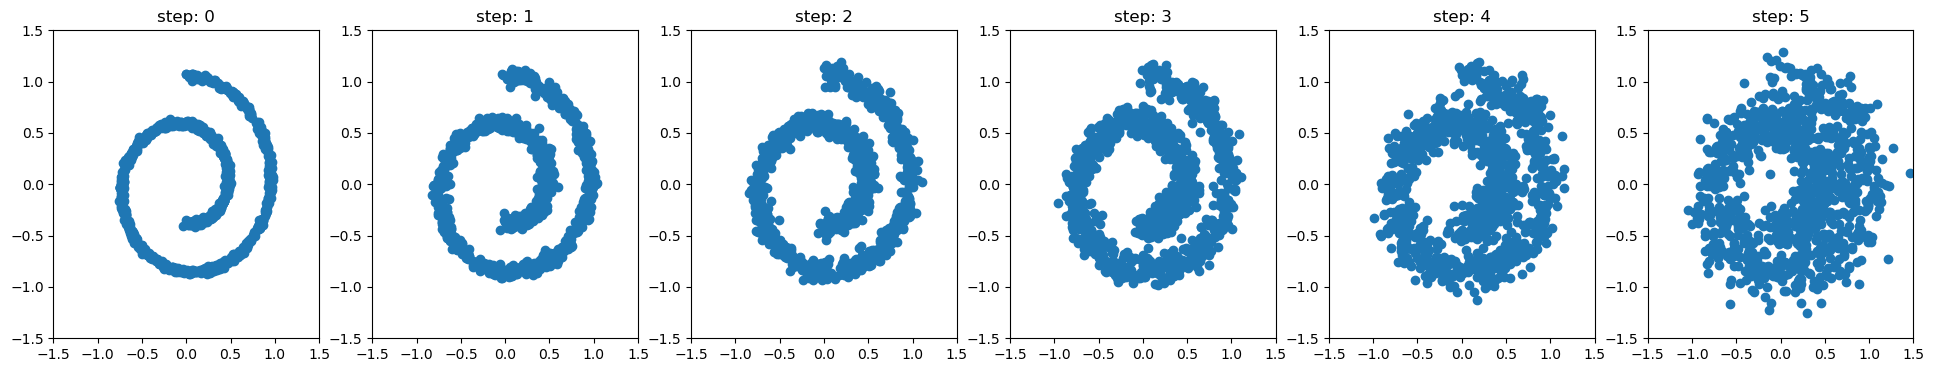

In [868]:
x_0, _ = sampler.sample(1024)

reference_trajectory = [x_0]
for t_step in torch.linspace(0, t_max - gamma, n_steps):
    t = torch.ones(x_0.size(0)) * t_step
    x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process)
    reference_trajectory.append(x_next)

print('Reference process')
_ = plot_trajectory(reference_trajectory, indices=[0, 1, 2, 5, 10, -1])

In [10]:
def compute_f_model_loss(model, reference, x_t, t, mean: bool = True):
    log_var = torch.tensor(2.0 * gamma).log()

    with torch.no_grad():
        x_t_p_gamma = make_euler_maruyama_step(x_t, t, gamma, f=reference)
    
    output = model(x_t_p_gamma, t + gamma)
    mean_pred = x_t_p_gamma + gamma * output.drift

    if output.contains('log_var'):
        log_var = output.log_var + log_var

    loss = 0.5 * (log_var + torch.exp(- log_var) * (mean_pred - x_t).pow(2))
    return loss.sum(-1).mean(), x_t_p_gamma

In [890]:
N_MAX_ITER = 4000
USE_MEAN_MATCHING = True

F_model = SimpleNet(64, 64, predict_log_var=True)
optim_F = torch.optim.Adam(F_model.parameters(), lr=1e-3)

ema_loss = utils.EMALoss()
var_crit = utils.VarCriterion(ema_loss.ema, threshold=5e-6, max_iter=N_MAX_ITER, measure_size=500)

with tqdm(total=N_MAX_ITER, leave=False) as pbar:
    while var_crit.check():
        traj_loss = 0
        optim_F.zero_grad(set_to_none=True)

        x_t, _ = sampler.sample(512)
        for t_step in torch.linspace(0, t_max - gamma, n_steps):
            t = torch.ones(512) * t_step

            loss, x_t = compute_f_model_loss(F_model, ref_process, x_t, t, mean=USE_MEAN_MATCHING)
        
            loss.backward()
            traj_loss += loss.item()

        ema_loss.update(traj_loss / n_steps)
        optim_F.step()

        pbar.update(1)
    pbar.close()

  0%|          | 0/4000 [00:00<?, ?it/s]

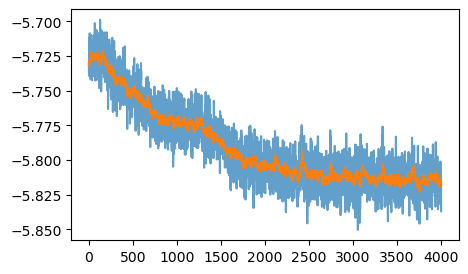

In [892]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.loss, alpha=0.7)
plt.plot(ema_loss.ema)
plt.show()

Reference Trajectory


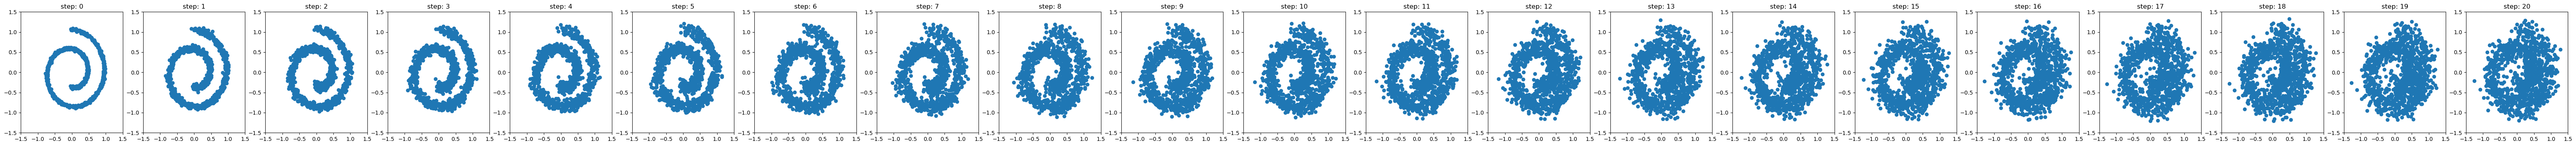

Learned Trajectory for F


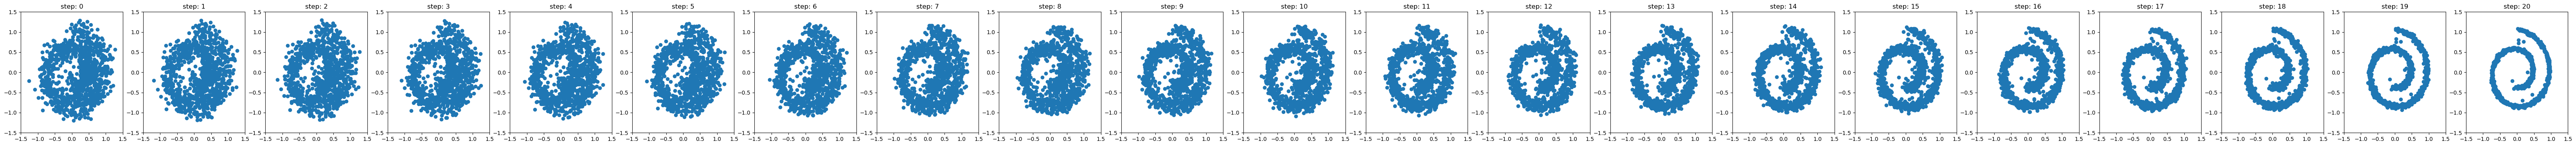

In [893]:
x_0, _  = sampler.sample(1024)

ref_trajectory = [x_0]
for t_step in torch.linspace(0, t_max - gamma, n_steps):
    t = torch.ones(1024) * t_step
    x_next = make_euler_maruyama_step(ref_trajectory[-1], t, gamma, f=ref_process)
    # print(x_next.var(0))
    ref_trajectory.append(x_next)

print('Reference Trajectory')
_ = plot_trajectory(ref_trajectory)

learned_trajectory = [ref_trajectory[-1]]
with torch.no_grad():
    for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
        t = torch.ones(1024) * t_step
        x_next = make_euler_maruyama_step(learned_trajectory[-1], t, gamma, f=F_model)
        learned_trajectory.append(x_next)

print('Learned Trajectory for F')
_ = plot_trajectory(learned_trajectory)

#### Full SBM

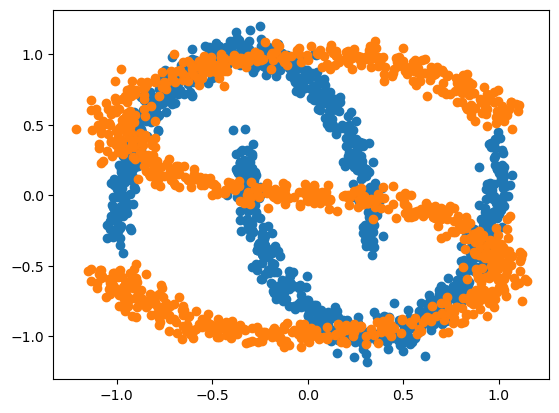

In [21]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='two_moons', p_0_args=[None, 0.05],
    p_1='s_curve', p_1_args=[None, 0.09],
)
x_0, x_1 = sampler.sample(1024)
scatter(x_0)
scatter(x_1)
plt.show()

In [13]:

# sb_trainer = SBTrainer(
#     F=F_model, B=B_model,
#     sampler=sampler,
#     alpha=4.0,
#     gamma=0.0006,
#     batch_size=256,
#     threshold=5e-6,
#     num_sb_steps=20,
#     lr_forward=8e-4,
#     lr_backward=8e-4,
#     max_num_iters_per_step=MAX_CONVERGENCE_ITER,
# )
# sb_trainer.train()

In [ ]:
def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


alpha = 4
gamma = 0.0006
t_max = 0.0120
n_steps = 20

BATCH_SIZE = 256
NUM_SB_ITERATIONS = 20
MAX_CONVERGENCE_ITER = 6000

B_model = SimpleNet(64, 64, predict_log_var=True)
F_model = SimpleNet(64, 64, predict_log_var=True)

optim_B = torch.optim.Adam(B_model.parameters(), lr=8e-4)
optim_F = torch.optim.Adam(F_model.parameters(), lr=8e-4)

In [31]:
for i in trange(NUM_SB_ITERATIONS):
    ema_loss = utils.EMALoss()
    var_crit = utils.VarCriterion(ema_loss.ema, threshold=5e-6, max_iter=MAX_CONVERGENCE_ITER, measure_size=500)

    with tqdm(leave=False, desc=f'step {i + 1}, training B model') as pbar:
        while var_crit.check():
            traj_loss = 0
            optim_B.zero_grad(set_to_none=True)
            
            _, x_t = sampler.sample(BATCH_SIZE)
            for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
                t = torch.ones(BATCH_SIZE) * t_step
                loss, x_t = compute_b_model_loss(B_model, ref_process if i == 0 else F_model, x_t, t, mean=True)   
                
                loss.backward()
                traj_loss += loss.item()

            ema_loss.update(traj_loss / n_steps)
            optim_B.step()
            
            pbar.update(1)
        pbar.close()

    ema_loss = utils.EMALoss()
    var_crit = utils.VarCriterion(ema_loss.ema, threshold=5e-6, max_iter=MAX_CONVERGENCE_ITER, measure_size=500)

    with tqdm(leave=False, desc=f'step {i + 1}, training F model') as pbar:
        while var_crit.check():
            traj_loss = 0
            optim_F.zero_grad(set_to_none=True)

            x_t, _ = sampler.sample(BATCH_SIZE)
            for t_step in torch.linspace(0, t_max - gamma, n_steps):
                t = torch.ones(BATCH_SIZE) * t_step
                loss, x_t = compute_f_model_loss(F_model, B_model, x_t, t, mean=True)
            
                loss.backward()
                traj_loss += loss.item()

            ema_loss.update(traj_loss / n_steps)
            optim_F.step()

            pbar.update(1)
        pbar.close()

  0%|          | 0/20 [00:00<?, ?it/s]

step 1, training B model: 0it [00:00, ?it/s]

step 1, training F model: 0it [00:00, ?it/s]

step 2, training B model: 0it [00:00, ?it/s]

step 2, training F model: 0it [00:00, ?it/s]

step 3, training B model: 0it [00:00, ?it/s]

step 3, training F model: 0it [00:00, ?it/s]

step 4, training B model: 0it [00:00, ?it/s]

step 4, training F model: 0it [00:00, ?it/s]

step 5, training B model: 0it [00:00, ?it/s]

step 5, training F model: 0it [00:00, ?it/s]

step 6, training B model: 0it [00:00, ?it/s]

step 6, training F model: 0it [00:00, ?it/s]

step 7, training B model: 0it [00:00, ?it/s]

step 7, training F model: 0it [00:00, ?it/s]

step 8, training B model: 0it [00:00, ?it/s]

step 8, training F model: 0it [00:00, ?it/s]

step 9, training B model: 0it [00:00, ?it/s]

step 9, training F model: 0it [00:00, ?it/s]

step 10, training B model: 0it [00:00, ?it/s]

step 10, training F model: 0it [00:00, ?it/s]

step 11, training B model: 0it [00:00, ?it/s]

step 11, training F model: 0it [00:00, ?it/s]

step 12, training B model: 0it [00:00, ?it/s]

KeyboardInterrupt: 

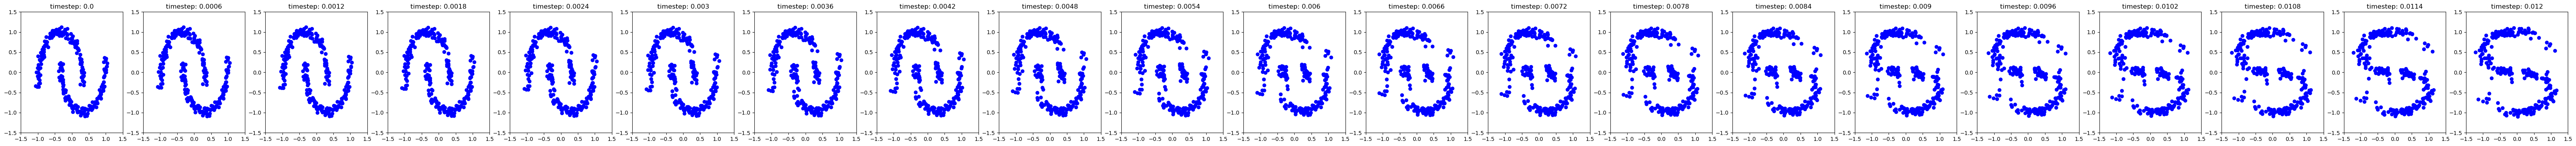

In [32]:
x_0, x_1 = sampler.sample(256)

trajectory = [x_0]
timesteps = []
with torch.no_grad():
    for t_step in torch.linspace(0, t_max - gamma, n_steps):
        timesteps.append(t_step.item())
        t = torch.ones(x_0.size(0)) * t_step
        x_next = make_euler_maruyama_step(trajectory[-1], t, gamma, f=B_model)
        trajectory.append(x_next)

timesteps.append(t_max)
fig = plot_trajectory(trajectory, timesteps)

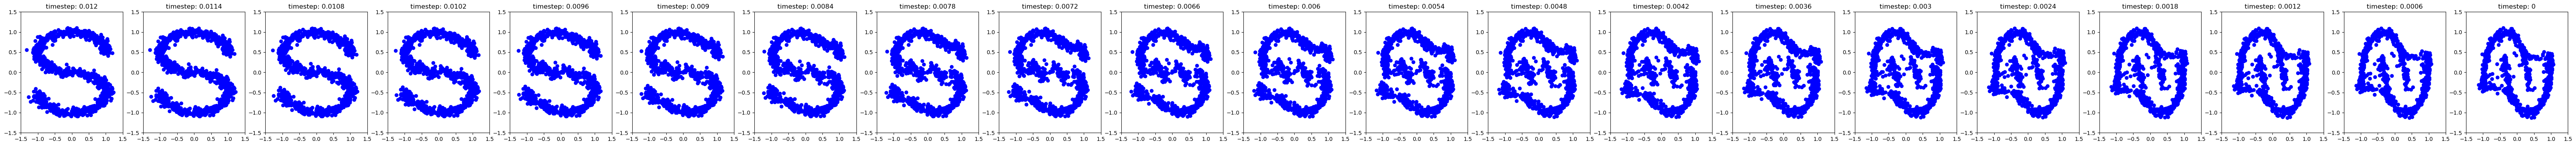

In [33]:
x_0, x_1 = sampler.sample(1024)

trajectory = [x_1]
timesteps = []
with torch.no_grad():
    for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
        timesteps.append(t_step.item())
        t = torch.ones(x_0.size(0)) * t_step
        x_next = make_euler_maruyama_step(trajectory[-1], t, gamma, f=F_model)
        trajectory.append(x_next)

timesteps.append(0)
fig = plot_trajectory(trajectory, timesteps)

# Energy based SB

In [104]:
def gaussian_energy(x, means, sigmas, mode_weights):
    '''
        x: Tensor[B, Dim] - input 
        means: Tensor[NModes, Dim]
        sigmax: Tensor[NModes, Dim, Dim]
    '''
    assert mode_weights.ndim == 1
    assert torch.allclose(mode_weights.sum(), torch.as_tensor(1.0))
    assert mode_weights.size(-1) == means.size(0)

    dim = x.size(-1)
    x = x.unsqueeze(1)
    means = means.unsqueeze(0)
    mode_weights = mode_weights.unsqueeze(0)
    diff = x - means

    det = torch.linalg.det(sigmas)
    inv_sigma = torch.linalg.inv(sigmas)
    
    unnormed_log_density = - 0.5 * torch.sum(
        einops.einsum(diff, inv_sigma, 'b m d, m d o -> b m o') * diff,
        dim=-1
    )

    norm_coeff = (2 * torch.pi * det)**(-dim / 2)
    norm_coeff = norm_coeff.unsqueeze(0)

    return -torch.log((norm_coeff * torch.exp(unnormed_log_density) * mode_weights).sum(-1))



class MixOfGaussians:
    def __init__(self, means, sigmas, mode_weights):
        self.means = means
        self.sigmas = sigmas
        self.mode_weights = mode_weights

    def energy(self, x):
        return gaussian_energy(x, self.means, self.sigmas, self.mode_weights) 


In [105]:
dim = 8
n_modes = 100
batch = 88

x = torch.randn(batch, dim)
means = torch.rand(n_modes, dim)
sigmas = torch.eye(dim).unsqueeze(0).repeat(n_modes, 1, 1)

mode_weights = torch.rand(n_modes)
mode_weights /= mode_weights.sum()

density = gaussian_energy(x, means, sigmas, mode_weights)
density

tensor([14.6712, 12.5398, 13.0929, 10.4961, 10.4748, 16.5235, 10.5340, 16.2065,
        10.3499, 11.5753, 12.2411, 13.5699, 11.8383, 14.5637,  9.6376, 13.5757,
        14.5102, 14.5995, 14.8165, 10.0979, 12.0320, 14.9855, 12.6846, 14.8730,
        11.9006, 11.9588, 11.1206, 14.2992, 11.7774,  9.2858, 12.9980, 12.9932,
        14.3432, 12.0974, 10.5801, 12.4323, 13.3486, 13.7481, 13.1583, 19.7355,
        12.4512, 10.4130, 11.5588, 11.4177, 11.1021,  9.9956, 10.4453, 14.8705,
        11.9942, 13.0729, 15.3158, 13.7758, 12.2154, 10.5048, 17.7987, 12.6770,
        11.5317, 18.6171, 12.3171, 10.2334, 13.5669, 14.7334, 13.3720, 10.6763,
        11.0410, 14.6941, 13.0826, 11.5654, 16.2501, 10.8333, 16.9234, 12.7857,
         9.8657, 11.3717, 10.9284, 12.3661, 16.5607, 12.2304, 11.2392, 13.9015,
        13.2197, 16.5340, 15.5005, 12.2394, 13.6975, 10.4200, 11.2541, 10.0457])

In [ ]:
def comput_tb_loss_backward(fwd_model, bwd_model, energy, t, dt, t_max, num_t_steps):
    fwd_tl_sum = 0
    bwd_tl_sum = 0
    x_t = ...
    
    var = torch.log(2)
    for t_step in torch.linsapce(0, t_max - dt, num_t_steps):
        t = torch.ones(...) * t_step

        x_t_pdt = make_euler_maruyama_step(x_t, t, dt, bwd_model, t_max=t_max)

        fwd_output = fwd_model(x_t_pdt, t + dt)
        bwd_output = bwd_model(x_t, t)

        fwd_tl_sum = fwd_tl_sum +





